In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [8]:
# reading in full data set
# brfss_total = pd.read_csv("../csv_data/brfss_total.csv")
brfss_total = pd.read_csv("./brfss_total.csv", index_col=0)

In [9]:
brfss_total.head()

,_STATE,DISPCODE,PHYSHLTH,MENTHLTH,USENOW3,HISPANC2,MARITAL,CHILDREN,EMPLOY,RENTHOM1,SEX,QLACTLM2,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,MSCODE,_IMPAGE,_RFHLTH,_SMOKER3,_PRACE,_EDUCAG,_INCOMG,_TOTINDA
0,5.0,110.0,0.0,0.0,3.0,2.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,53.0,1.0,4.0,1.0,3.0,5.0,1.0
1,5.0,110.0,15.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,5.0,64.0,2.0,3.0,1.0,2.0,2.0,1.0
2,5.0,110.0,6.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,58.0,1.0,4.0,1.0,3.0,2.0,1.0
3,5.0,110.0,30.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,76.0,2.0,4.0,1.0,1.0,0.0,2.0
4,5.0,110.0,13.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,82.0,2.0,3.0,1.0,2.0,0.0,2.0


In [10]:
# just making sure no nulls are present
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117555 entries, 0 to 117554
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    117555 non-null  float64
 1   DISPCODE  117555 non-null  float64
 2   PHYSHLTH  117555 non-null  float64
 3   MENTHLTH  117555 non-null  float64
 4   USENOW3   117555 non-null  float64
 5   HISPANC2  117555 non-null  float64
 6   MARITAL   117555 non-null  float64
 7   CHILDREN  117555 non-null  float64
 8   EMPLOY    117555 non-null  float64
 9   RENTHOM1  117555 non-null  float64
 10  SEX       117555 non-null  float64
 11  QLACTLM2  117555 non-null  float64
 12  ACEDEPRS  117555 non-null  float64
 13  ACEDRINK  117555 non-null  float64
 14  ACEDRUGS  117555 non-null  float64
 15  ACEPRISN  117555 non-null  float64
 16  ACEDIVRC  117555 non-null  float64
 17  ACEPUNCH  117555 non-null  float64
 18  ACEHURT   117555 non-null  float64
 19  ACESWEAR  117555 non-null  float64
 20  ACET

In [11]:
np.random.seed(151)

In [12]:
# creating X variable with all features
X_all = brfss_total.drop(columns=['USENOW3', 'QLACTLM2', '_RFHLTH', '_SMOKER3'])

In [13]:
# creating the 4 y's
y_tobacco = brfss_total['USENOW3']
y_activity = brfss_total['QLACTLM2']
y_health = brfss_total['_RFHLTH']
y_smoker = brfss_total['_SMOKER3']

In [14]:
#original baseline for tobacco
y_tobacco.value_counts(normalize=True)

3.0    0.966560
1.0    0.017872
2.0    0.012990
0.0    0.002578
Name: USENOW3, dtype: float64

In [15]:
#original baseline for activity
y_activity.value_counts(normalize=True)

2.0    0.724520
1.0    0.268997
0.0    0.006482
Name: QLACTLM2, dtype: float64

In [16]:
#original baseline for health
y_health.value_counts(normalize=True)

1.0    0.814742
2.0    0.181991
0.0    0.003267
Name: _RFHLTH, dtype: float64

In [17]:
#original baseline for smoker
y_smoker.value_counts(normalize=True)

4.0    0.521569
3.0    0.308324
1.0    0.119604
2.0    0.044226
0.0    0.006278
Name: _SMOKER3, dtype: float64

In [18]:
# splitting X up so I can do some engineering on the nominal data and ACE columns
X_num = X_all[['PHYSHLTH', 'MENTHLTH', 'CHILDREN']]
X_cat = X_all[['_STATE', 'DISPCODE', 'HISPANC2', 'MARITAL', 'EMPLOY', 'RENTHOM1', 'SEX', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 
               'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX', 'MSCODE', 
               '_IMPAGE', '_PRACE', '_EDUCAG', '_INCOMG','_TOTINDA']]

In [19]:
# turning the nominal columns into strings so they can be dummified
X_cat = X_cat.astype(str)

In [20]:
# dummifying nominal variables for X_all
X_dummies = pd.get_dummies(X_cat, drop_first=True)
X_dummies.head()

,_STATE_15.0,_STATE_19.0,_STATE_22.0,_STATE_27.0,_STATE_30.0,_STATE_32.0,_STATE_37.0,_STATE_40.0,_STATE_47.0,_STATE_5.0,_STATE_50.0,_STATE_53.0,_STATE_55.0,DISPCODE_1100.0,DISPCODE_120.0,DISPCODE_1200.0,HISPANC2_1.0,HISPANC2_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,EMPLOY_1.0,EMPLOY_2.0,EMPLOY_3.0,EMPLOY_4.0,EMPLOY_5.0,EMPLOY_6.0,RENTHOM1_1.0,RENTHOM1_2.0,RENTHOM1_3.0,SEX_2.0,ACEDEPRS_1.0,ACEDEPRS_2.0,ACEDRINK_1.0,ACEDRINK_2.0,ACEDRUGS_1.0,ACEDRUGS_2.0,...,_IMPAGE_74.0,_IMPAGE_75.0,_IMPAGE_76.0,_IMPAGE_78.0,_IMPAGE_79.0,_IMPAGE_80.0,_IMPAGE_81.0,_IMPAGE_82.0,_IMPAGE_83.0,_IMPAGE_84.0,_IMPAGE_85.0,_IMPAGE_86.0,_IMPAGE_87.0,_IMPAGE_89.0,_IMPAGE_90.0,_IMPAGE_91.0,_IMPAGE_92.0,_IMPAGE_93.0,_IMPAGE_94.0,_IMPAGE_95.0,_IMPAGE_96.0,_IMPAGE_97.0,_IMPAGE_98.0,_PRACE_1.0,_PRACE_2.0,_PRACE_3.0,_PRACE_4.0,_PRACE_5.0,_PRACE_6.0,_EDUCAG_1.0,_EDUCAG_2.0,_EDUCAG_3.0,_EDUCAG_4.0,_INCOMG_1.0,_INCOMG_2.0,_INCOMG_3.0,_INCOMG_4.0,_INCOMG_5.0,_TOTINDA_1.0,_TOTINDA_2.0
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [21]:
X_num.head()

,PHYSHLTH,MENTHLTH,CHILDREN
0,0.0,0.0,1.0
1,15.0,0.0,0.0
2,6.0,0.0,0.0
3,30.0,0.0,0.0
4,13.0,0.0,0.0


In [22]:
# merging numerical and nominal data into one data frame
X_all = X_num.merge(X_dummies, left_index=True, right_index=True)

In [23]:
X_all.shape

(117555, 165)

In [24]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X_all1, y_tobacco = sm.fit_resample(X_all, y_tobacco)

sm2 = SMOTE(random_state=151)
X_all2, y_activity = sm2.fit_resample(X_all, y_activity)

sm3 = SMOTE(random_state=151)
X_all3, y_health = sm3.fit_resample(X_all, y_health)

sm4 = SMOTE(random_state=151)
X_all4, y_smoker = sm4.fit_resample(X_all, y_smoker)

In [ ]:
#y_tobacco.value_counts(normalize=True)

In [ ]:
#y_activity.value_counts(normalize=True)

In [ ]:
#y_health.value_counts(normalize=True)

In [ ]:
#y_smoker.value_counts(normalize=True)

In [25]:
# looks like with SMOTE resampling, data set has increased about 4x
X_all1.shape

(454496, 165)

In [26]:
# creating training and testing sets for all y's
X_train_all, X_test_all, y_train_tobacco, y_test_tobacco = train_test_split(X_all1, y_tobacco, random_state = 151, stratify=y_tobacco)
X_train_all2, X_test_all2, y_train_activity, y_test_activity = train_test_split(X_all2, y_activity, random_state = 151, stratify=y_activity)
X_train_all3, X_test_all3, y_train_health, y_test_health = train_test_split(X_all3, y_health, random_state = 151, stratify=y_health)
X_train_all4, X_test_all4, y_train_smoker, y_test_smoker = train_test_split(X_all4, y_smoker, random_state = 151, stratify=y_smoker)

In [27]:
X_train_all.shape

(340872, 165)

In [28]:
y_train_tobacco.shape

(340872,)

In [29]:
pipe_all_tobacco = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=3, n_estimators=500))
pipe_all_tobacco.fit(X_train_all, y_train_tobacco)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

In [30]:
pipe_all_activity = make_pipeline(StandardScaler(), xgb.XGBClassifier(learning_rate = 1, max_depth = 5, n_estimators=25))
pipe_all_activity.fit(X_train_all2, y_train_activity)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=None,
                               n_estimators=25, n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [31]:
pipe_all_health = make_pipeline(SelectKBest(f_classif, k=151), StandardScaler(), ExtraTreesClassifier(max_depth=None, n_estimators=500))
pipe_all_health.fit(X_train_all3, y_train_health)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=151,
                             score_func=<function f_classif at 0x7f8f43b15d90>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=None,
                                   

In [32]:
pipe_all_smoker = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=3, n_estimators=500))
pipe_all_smoker.fit(X_train_all4, y_train_smoker)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

In [33]:
# getting predictions for each model
tobacco_all_preds = pipe_all_tobacco.predict(X_test_all)
activity_all_preds = pipe_all_activity.predict(X_test_all2)
health_all_preds = pipe_all_health.predict(X_test_all3)
smoker_all_preds = pipe_all_smoker.predict(X_test_all4)

# calculating the precision score for each model
tobacco_all_prec = precision_score(y_test_tobacco, tobacco_all_preds, average='micro')
activity_all_prec = precision_score(y_test_activity, activity_all_preds, average='micro')
health_all_prec = precision_score(y_test_health, health_all_preds, average='micro')
smoker_all_prec = precision_score(y_test_smoker, smoker_all_preds, average='micro')

In [34]:
print(f'training accuracy for tobacco: {cross_val_score(pipe_all_tobacco, X_train_all, y_train_tobacco, cv=3).mean()}')
print(f'testing accuracy for tobacco: {cross_val_score(pipe_all_tobacco, X_test_all, y_test_tobacco, cv=3).mean()}')
print(f'Precision for tobacco: {tobacco_all_prec}')

training accuracy for tobacco: 0.9925162524349317
testing accuracy for tobacco: 0.9881891111010029
Precision for tobacco: 0.9923255650214743


In [35]:
print(f'training accuracy for activity: {cross_val_score(pipe_all_activity, X_train_all2, y_train_activity, cv=3).mean()}')
print(f'testing accuracy for activity: {cross_val_score(pipe_all_activity,X_test_all2, y_test_activity, cv=3).mean()}')
print(f'Precision for activity: {activity_all_prec}')

training accuracy for activity: 0.8816702672803366
testing accuracy for activity: 0.870880884171637
Precision for activity: 0.8804928067126911


In [36]:
print(f'training accuracy for health: {cross_val_score(pipe_all_health, X_train_all3, y_train_health, cv=3).mean()}')
print(f'testing accuracy for health: {cross_val_score(pipe_all_health, X_test_all3, y_test_health, cv=3).mean()}')
print(f'Precision for health: {health_all_prec}')

training accuracy for health: 0.9520830845595206
testing accuracy for health: 0.9295727547475048
Precision for health: 0.9587376275527961


In [37]:
print(f'training accuracy for smoker: {cross_val_score(pipe_all_smoker, X_train_all4, y_train_smoker, cv=3).mean()}')
print(f'testing accuracy for smoker: {cross_val_score(pipe_all_smoker, X_test_all4, y_test_smoker, cv=3).mean()}')
print(f'Precision for smoker: {smoker_all_prec}')

training accuracy for smoker: 0.7984281694306355
testing accuracy for smoker: 0.7264424533679987
Precision for smoker: 0.8177631063907518


In [47]:
def no_k(pipe, model_name):
  '''Function that takes in a pipe that has been fit without feature selection
   to data and outputs a dataframe with feature importances
   
  model: model that has been fitted
  model_name: string name of the model (should not include spaces between words)'''

  #getting features importances
  df = pd.DataFrame({'features': X_all.columns.values, 'importance':pipe.named_steps[model_name].feature_importances_})
  df = df.sort_values('importance', ascending = False)

  return df

In [48]:
tobacco_all = no_k(pipe_all_tobacco, 'randomforestclassifier')

In [49]:
tobacco_all.head(10)

,features,importance
36,SEX_2.0,0.074525
44,ACEPRISN_2.0,0.036039
62,ACEHVSEX_1.0,0.033530
59,ACETTHEM_1.0,0.031563
11,_STATE_47.0,0.031433
38,ACEDEPRS_2.0,0.023525
42,ACEDRUGS_2.0,0.022641
56,ACETOUCH_1.0,0.020875
47,ACEPUNCH_1.0,0.020193
50,ACEHURT_1.0,0.019651


In [50]:
# looking at last 10
tobacco_all.tail(10)

,features,importance
134,_IMPAGE_84.0,3.152713e-04
136,_IMPAGE_86.0,1.803552e-04
138,_IMPAGE_89.0,1.497596e-04
141,_IMPAGE_92.0,1.269208e-04
142,_IMPAGE_93.0,9.877894e-05
144,_IMPAGE_95.0,5.636152e-05
143,_IMPAGE_94.0,4.917897e-06
145,_IMPAGE_96.0,8.844045e-07
146,_IMPAGE_97.0,8.234064e-07
147,_IMPAGE_98.0,2.010795e-07


**Looks like being a senior citizen has the least amount of influence on smokeless tobacco usage**

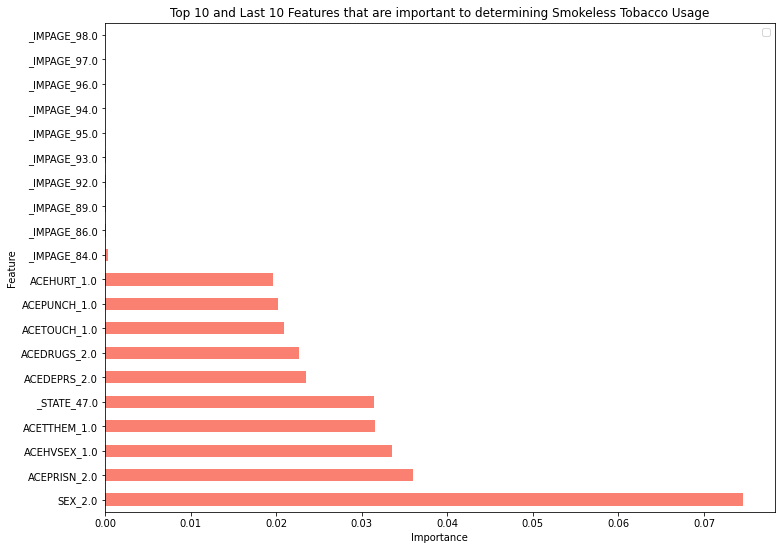

In [51]:
def top_bottom(df, color):
  ''' Function to graph Top 10 and Last 10 Features based on importance'''
  top_bottom = pd.merge(df.head(10), df.tail(10), how='outer')
  top_bottom.plot(kind='barh', figsize=(12, 9), color=color)
  plt.yticks(ticks=top_bottom.index, labels=top_bottom.features)
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.legend([]);
  return

top_bottom(tobacco_all, color = 'salmon')
plt.title('Top 10 and Last 10 Features that are important to determining Smokeless Tobacco Usage');

plt.savefig('tobacco_all_ungrouped.jpg')

In [53]:
activity_all = no_k(pipe_all_activity, 'xgbclassifier')
activity_all.head(10)

,features,importance
62,ACEHVSEX_1.0,0.084915
11,_STATE_47.0,0.051749
27,EMPLOY_1.0,0.026642
23,MARITAL_3.0,0.022939
30,EMPLOY_4.0,0.021858
13,_STATE_50.0,0.021680
40,ACEDRINK_2.0,0.019759
14,_STATE_53.0,0.016804
31,EMPLOY_5.0,0.016325
28,EMPLOY_2.0,0.016278


In [54]:
activity_all.tail(10)

,features,importance
73,_IMPAGE_22.0,0.000730
71,_IMPAGE_20.0,0.000677
147,_IMPAGE_98.0,0.000639
74,_IMPAGE_23.0,0.000478
153,_PRACE_6.0,0.000474
43,ACEPRISN_1.0,0.000190
146,_IMPAGE_97.0,0.000000
76,_IMPAGE_25.0,0.000000
145,_IMPAGE_96.0,0.000000
143,_IMPAGE_94.0,0.000000


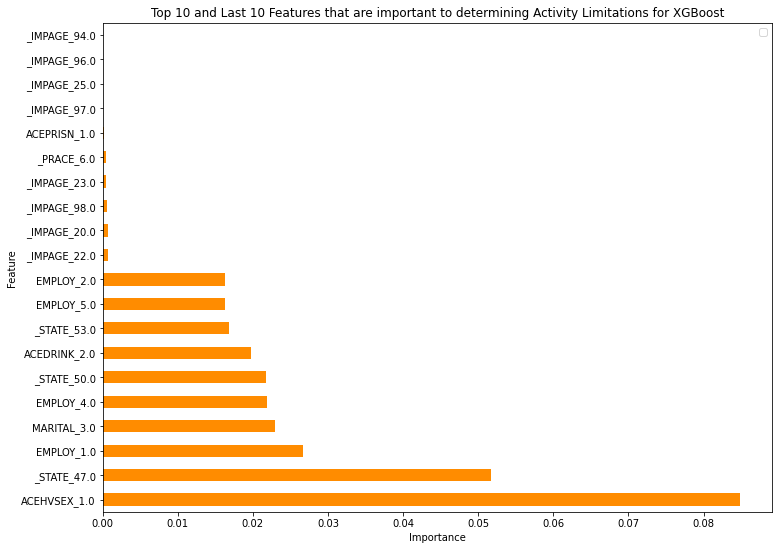

In [55]:
top_bottom(activity_all, color = 'darkorange')
plt.title('Top 10 and Last 10 Features that are important to determining Activity Limitations for XGBoost');

plt.savefig('activity_all_ungrouped.jpg')

In [56]:
smoker_all = no_k(pipe_all_smoker, 'randomforestclassifier')
smoker_all.head(10)

,features,importance
0,PHYSHLTH,0.025168
36,SEX_2.0,0.024493
1,MENTHLTH,0.023297
27,EMPLOY_1.0,0.020927
2,CHILDREN,0.019789
157,_EDUCAG_4.0,0.019748
11,_STATE_47.0,0.018181
33,RENTHOM1_1.0,0.017815
21,MARITAL_1.0,0.016908
162,_INCOMG_5.0,0.016637


In [57]:
smoker_all.tail(10)

,features,importance
70,_IMPAGE_19.0,0.000749
18,DISPCODE_1200.0,0.000733
69,_IMPAGE_18.0,0.000646
142,_IMPAGE_93.0,0.000378
140,_IMPAGE_91.0,0.000306
145,_IMPAGE_96.0,0.000192
143,_IMPAGE_94.0,0.000178
144,_IMPAGE_95.0,0.000053
146,_IMPAGE_97.0,0.000011
147,_IMPAGE_98.0,0.000005


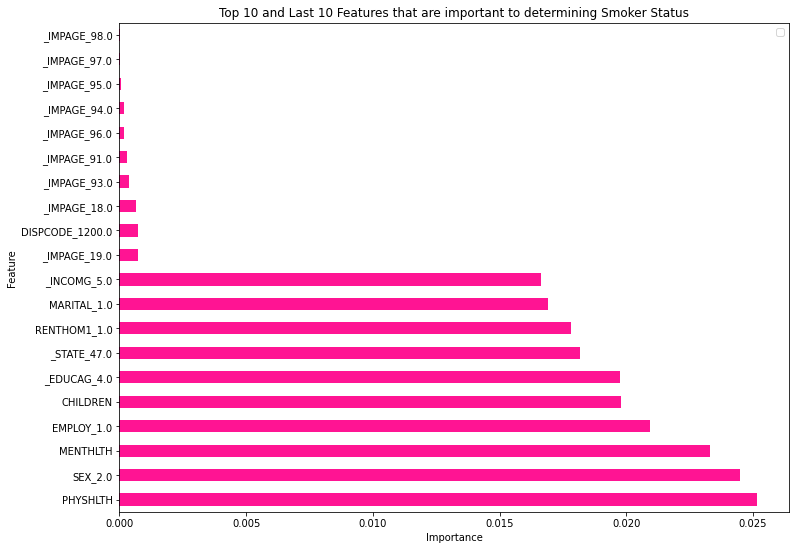

In [58]:
top_bottom(smoker_all, color='deeppink')
plt.title('Top 10 and Last 10 Features that are important to determining Smoker Status');

plt.savefig('smoker_all_ungrouped.jpg')

In [59]:
# getting features selected by 'selectkbest' for health
features_health_all = pipe_all_health.named_steps['selectkbest'].get_support(indices=True) 

In [60]:
# getting column names for features selected by 'selectkbest' for health
X_cols_health_all = X_all.columns.values[features_health_all]

In [61]:
# getting each feature's importance for health
coefs_health_all = pipe_all_health.named_steps['extratreesclassifier'].feature_importances_

In [62]:
# feature importances for self-reported health
health_all = pd.DataFrame({'features': X_cols_health_all, 'importance':coefs_health_all})
health_all = health_all.sort_values('importance', ascending = False)
health_all.head(10)

,features,importance
0,PHYSHLTH,0.078513
26,EMPLOY_1.0,0.037962
148,_INCOMG_5.0,0.031658
1,MENTHLTH,0.024787
35,SEX_2.0,0.021857
150,_TOTINDA_2.0,0.021707
144,_EDUCAG_4.0,0.021397
149,_TOTINDA_1.0,0.021248
32,RENTHOM1_1.0,0.019908
62,MSCODE_1.0,0.019497


In [63]:
health_all.tail(10)

,features,importance
72,_IMPAGE_24.0,0.000592
67,_IMPAGE_19.0,0.000489
79,_IMPAGE_31.0,0.000488
78,_IMPAGE_30.0,0.000442
69,_IMPAGE_21.0,0.000389
66,_IMPAGE_18.0,0.000358
68,_IMPAGE_20.0,0.000320
70,_IMPAGE_22.0,0.000283
131,_IMPAGE_92.0,0.000281
133,_IMPAGE_94.0,0.000171


**Looks like a few ages don't have a big influence on perceived health**

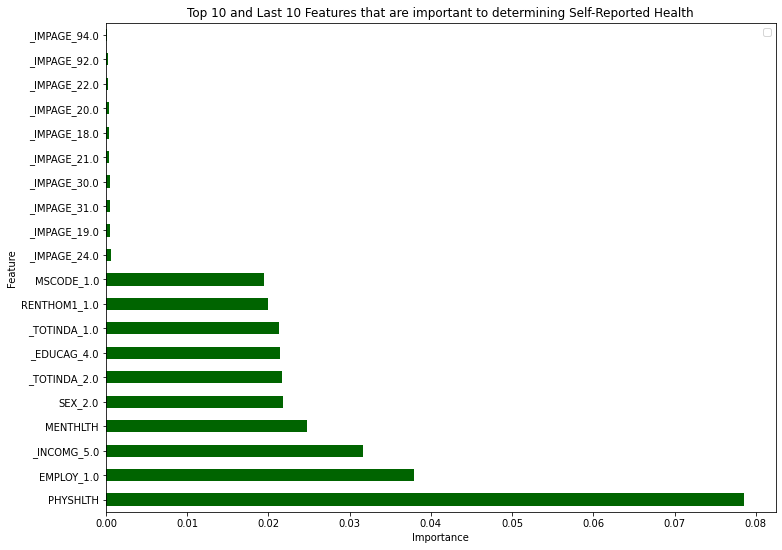

In [64]:
top_bottom(health_all, color = 'darkgreen')
plt.title('Top 10 and Last 10 Features that are important to determining Self-Reported Health');

plt.savefig('health_all_ungrouped.jpg')